<style>
h1 {text-align: center; font-family: Georgia; font-size: 36px; font-weight: bold; line-height: 48px}
h2 {font-family: Calisto MT; font-size: 30px; font-weight: bold; color: #6a085c}
h3 {font-family: Lucida Bright; font-size: 24px; font-weight: bold; color: #114a4f}
h4 {text-indent: 2em; font-family: Cambria; font-size: 18px}
p.text {text-indent: 2em; text-align: justify; font-family: Times New Roman; font-size: 20px}
p.ex {text-align: center; font-family: Times New Roman; font-size: 20px}
table.t {width: 80%; border: 1px solid; padding: 5px; border-collapse: collapse}
th.h {text-align: left; font-family: Georgia; font-size: 18px; border: 1px solid; padding: 5px}
td.d {text-align: left; font-family: Cambria; font-size: 18px; border: 1px solid; padding: 5px}
code {font-family: monospace; font-weight: bold; font-size: 16px; color: crimson; padding: 4px}
</style>

<h1>Formalizing Informal Text using Natural Language Processing</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu
title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 18}
label_font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

<h2>1. Simple Encoder Decoder Network:</h2>

<p class = "text">
The seq2seq model consists of two subnetworks, the encoder and the decoder. The encoder, on the left hand, receives sequences from the source language as inputs and produces, as a result, a compact representation of the input sequence, trying to summarize or condense all of its information. Then that output becomes an input or initial state to the decoder, which can also receive another external input. At each time step, the decoder generates an element of its output sequence based on the input received and its current state, as well as updating its own state for the next time step. Here's a simple pictorial representation of how our model will work.
</p>

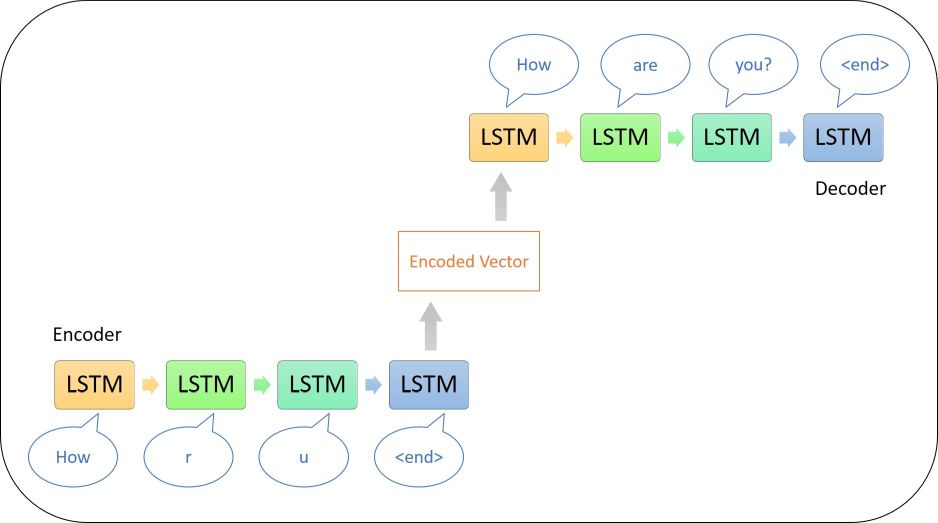

In [ ]:
from IPython.display import Image
Image(filename = "EncDec.jpg")

<h3>1.1. Designing Encoder:</h3>
<p class = "text">
The encoder will take sequential word embeddings of the source sentences as input at each time step, and encode its information in encoded vector using current state and LSTM hidden state. Hence, at the output of encoder, we get an encoded vector of source sentence which can be thought of as latent information vector.
</p>

In [2]:
class Encoder(tf.keras.Model):
    '''
    Encoder model takes a input sequence and returns Encoder outputs as encoder_final_hidden_state, encoder_final_current_state
    '''
    def __init__(self, inp_vocab_size, lstm_size, input_length):
        '''
          This method intializes the Encoder model.
        '''
        super().__init__()
        # Initializing the parameters
        self.inp_vocab_size = inp_vocab_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        # Initializing Embedding layer
        self.embedding = Embedding(input_dim = self.inp_vocab_size, output_dim = self.inp_vocab_size,
                                   embeddings_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 1, seed = 859),
                                   input_length = self.input_length, mask_zero = True, name = "Encoder_Embedding")
        #Intializing Encoder LSTM layer
        self.lstm1 = LSTM(self.lstm_size, return_state = True, return_sequences = True,
                          kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 859),
                          recurrent_initializer = tf.keras.initializers.orthogonal(seed = 859), name = "Encoder_LSTM1")
        self.lstm2 = LSTM(self.lstm_size, return_state = True, return_sequences = True,
                          kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 859),
                          recurrent_initializer = tf.keras.initializers.orthogonal(seed = 859), name = "Encoder_LSTM2")

    def call(self, input):
        '''
          This method takes a sequence input and the initial states of the Encoder as inputs.
          Sequence input is passed to the Embedding layer and initial states are passed to the LSTM layer of the Encoder model.
          It returns Encoder outputs as last time step's hidden and current states.
        '''
        # Unpacking the input
        input_sequence, states = input[0], input[1]
        # Passing input sequence to embedding layer
        input_embedded = self.embedding(input_sequence)
        # Passing embedidng layer output to lstm layer
        self.enc_output, self.last_hidden_state, self.last_current_state = self.lstm1(input_embedded, initial_state = states)
        self.enc_output, self.last_hidden_state, self.last_current_state = self.lstm2(self.enc_output, [self.last_hidden_state, self.last_current_state])
        # Returning the outputs
        return self.enc_output, self.last_hidden_state, self.last_current_state
      
    def initialize_states(self, batch_size):
      '''
        Given a batch size this method will return intial hidden state and intial current state.
        If batch size is 32, Hidden state is zeros of size [32,lstm_units], current state is zeros is of size [32,lstm_units]
      '''
      self.first_hidden_state, self.first_current_state = tf.zeros([batch_size, self.lstm_size]), tf.zeros([batch_size, self.lstm_size])
      # Returning the initializations
      return self.first_hidden_state, self.first_current_state

<h3>1.2. Designing Decoder:</h3>
<p class = "text">
The decoder is designed in the same as Encoder as its the chain of LSTM units where, the hidden state of the first unit is the encoder vector, and the rest of the units accept the hidden state from the previous unit.
</p>

In [3]:
class Decoder(tf.keras.Model):
    '''
    Decoder model takes an encoded vector of input sequence and returns output sequence
    '''
    def __init__(self, out_vocab_size, lstm_size, input_length):
        '''
          This method intializes the Encoder model.
        '''
        super().__init__()
        # Initializing the parameters
        self.out_vocab_size = out_vocab_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        # Initializing Embedding layer
        self.embedding = Embedding(input_dim = self.out_vocab_size, output_dim = self.out_vocab_size, input_length = self.input_length, mask_zero = True,
                                   name = "embedding_layer_decoder")
        # Intializing Decoder LSTM layer
        self.lstm = LSTM(self.lstm_size, return_sequences = True, return_state = True, name = "Encoder_LSTM")

    def call(self, input):
        '''
          This method takes a sequence input and the last current state of the Encoder as inputs.
          Sequence input is passed to the Embedding layer and Encoder current states are passed to the LSTM layer of the Decoder model.
          It returns Decoder outputs as last time step's hidden and current states.
        '''
        # Unpacking the input
        input_sequence, states = input[0], input[1]
        # Passing input sequence to embedding layer
        target_embedd = self.embedding(input_sequence)
        # Passing embedidng layer output to lstm layer
        dec_output, last_hidden_state, last_current_state = self.lstm(target_embedd, initial_state = states)
        # Returning the outputs
        return dec_output, last_hidden_state, last_current_state

<h3>1.3. Designing Encoder Decoder Model:</h3>
<p class = "text">
Now that we have Encoder and decoder models, we can now integrate them in Encoder Decoder model. We will add an additional dense layer as output layer whose output is calculated using a softmax function to obtain a probability for every token in the output vocabulary.
</p>

In [4]:
class Encoder_Decoder(tf.keras.Model):
    '''
    The Encoder_Decoder Model initializes both Encoder and Decoder Models and outputs normalized probabilties of the tokens in target vocabulary.
    '''
    def __init__(self, inp_vocab_size, out_vocab_size, lstm_size, input_length, batch_size):
        '''
          This method intializes the both the Encoder and Decoder models
        '''
        super().__init__()
        # Initializing the parameters
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.inp_vocab_size = inp_vocab_size + 1
        self.out_vocab_size = out_vocab_size + 1
        self.batch_size = batch_size
        #Creating Encoder model object
        self.encoder = Encoder(inp_vocab_size = self.inp_vocab_size, lstm_size = self.lstm_size, input_length = self.input_length)
        #Creating Decoder model object
        self.decoder = Decoder(out_vocab_size = self.out_vocab_size, lstm_size = self.lstm_size, input_length = self.input_length)
        #Intializing Dense layer of length out_vocab_size with softmax activation
        self.dense   = Dense(self.out_vocab_size, activation = 'softmax')
    
    def call(self, data):
        '''
        This method takes data from data pipeline in tuples of length 2, where first is encoder_inp and second is decoder_inp
        encoder_inp is fed to Encoder model object alongwith initial states whereas decoder_inp is fed to decoder model object alongwith
        Encoder last hidden and current states.
        The Model then returns normalized output probabilities of tokens in target vocabulary.
        '''
        # Unpacking data
        enc_inp, dec_inp = data[0], data[1]
        # Initializing Encoder initial states
        initial_state = self.encoder.initialize_states(self.batch_size)
        # Calling Encoder model object
        encoder_output, encoder_hidden, encoder_current = self.encoder([enc_inp, initial_state])
        # Calling Decoder model object
        decoder_output, decoder_hidden, decoder_current = self.decoder([dec_inp, [encoder_hidden, encoder_current]])
        # Calling output dense layer
        output = self.dense(decoder_output)
        # Returning outputs
        return output

<h2>2. Designing the Data Pipeline:</h2>

<p class = "text">
We have to build a data pipeline to train the model as model expects tuples of length batch size of preprocessed data at runtime. We will load the source and target tokenizers and pad the data into sequences. Then, feed it according to the batch size.
</p>

<h3>2.1. Preprocessing the Data:</h3>
<p class = "text">
We will first convert sentences into sequences by tokenizing and padding.
</p>

In [5]:
class Dataset:
    '''
    Generic class used to preprocess the data
    '''
    def __init__(self, data, tknizer_informal, tknizer_formal, max_len):
        '''
        This method intializes input sequences and the tokenizers
        '''
        self.encoder_inps = data['encoder_inp'].values
        self.decoder_inps = data['decoder_inp'].values
        self.decoder_outs = data['decoder_out'].values
        self.tknizer_informal = tknizer_informal
        self.tknizer_formal = tknizer_formal
        self.max_len = max_len

    def __getitem__(self, i):
        '''
        This method tokenizes the data and pads it with zeros to make all the sequences of same length
        '''
        # Tokenizing the sequences by passing them in lists as required by tokenizer
        self.encoder_inp_seq = self.tknizer_informal.texts_to_sequences([self.encoder_inps[i]])
        self.decoder_inp_seq = self.tknizer_formal.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_formal.texts_to_sequences([self.decoder_outs[i]])
        # Padding the sequences with zeros
        self.encoder_inp_seq = pad_sequences(self.encoder_inp_seq, maxlen = self.max_len, dtype = 'int32', padding = 'post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen = self.max_len, dtype = 'int32', padding = 'post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen = self.max_len, dtype = 'int32', padding = 'post')
        return self.encoder_inp_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self):
        '''
        This method is required by model.fit method at runtime to keep logs
        '''
        return len(self.encoder_inps)

<h3>2.2. Creating Dataloader:</h3>
<p class = "text">
we will now design a dataloader which shuffles the preprocessed dataset and returns the tuple of form ([[encoder_inp], [decoder_inp]], decoder_out) at runtime
</p>

In [6]:
class Dataloader(tf.keras.utils.Sequence):    
    '''
    Keras Dataloader instance to feed the model with preprocessed data at runtime
    '''
    def __init__(self, dataset, batch_size = 1):
        '''
        this method initializes preprocessed dataset and batch size
        '''
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))

    def __getitem__(self, i):
        '''
        This method is used to pack the input data in tuples of form ([[encoder_inp], [decoder_inp]], decoder_out)
        '''
        # Tracking indices of start and stop
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        # Creating data in tuples of form ([[encoder_inp], [decoder_inp]], decoder_out)
        batch = [np.squeeze(np.stack(samples, axis = 1), axis = 0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):
        '''
        This method is required by model.fit method at runtime to keep logs
        '''
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        '''
        This method is a callback to shuffle the indices of data on each epoch
        '''
        self.indexes = np.random.permutation(self.indexes)

<p class = "text">
We can now create the dataloader objects for train, validation and test sets. We will load the train, validation, test sets and tokenizers from pickle objects.
</p>

In [7]:
# Lading pickle objects
train = joblib.load('train.pkl')
validation = joblib.load('validation.pkl')
test = joblib.load('test.pkl')
tknizer_informal = joblib.load('tknizer_informal.pkl')
tknizer_formal = joblib.load('tknizer_formal.pkl')
print(f"Shape of Training set: {train.shape}")
print(f"Shape of Validation set: {validation.shape}")
print(f"Shape of Test set: {test.shape}")
# Printing sizes of vocabularies
vocab_size_informal = len(tknizer_informal.word_index.keys())
print(f"Vocab size of Informal text: {vocab_size_informal}")
vocab_size_formal = len(tknizer_formal.word_index.keys())
print(f"Vocab size of Formal text: {vocab_size_formal}")

Shape of Training set: (1805, 3)
Shape of Validation set: (100, 3)
Shape of Test set: (95, 3)
Vocab size of Informal text: 103
Vocab size of Formal text: 91


In [8]:
# Defining parameters
BATCH_SIZE = 64
MAX_LEN = 200
# Preprocessing data
train_dataset = Dataset(train, tknizer_informal, tknizer_formal, MAX_LEN)
validation_dataset  = Dataset(validation, tknizer_formal, tknizer_formal, MAX_LEN)
# Creating Dataloader
train_dataloader = Dataloader(train_dataset, batch_size = BATCH_SIZE)
validation_dataloader = Dataloader(validation_dataset, batch_size = BATCH_SIZE)
# Checking the dimensions 
print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 200) (64, 200) (64, 200)


<h2>3. Training the Encoder Decoder Model:</h2>

<h3>3.1. Creating model callbacks:</h3>
<p class = "text">
we will now design a tensorboard callback to keep track of train and validation losses. 
</p>

In [9]:
def create_tensorboard_cb(model):
    '''
    Takes path string as input and returns tensorboard callback initialized in that path.
    '''
    import time
    root_logdir = os.path.join(os.curdir, model)
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    logdir = os.path.join(root_logdir, run_id)
    return tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)

<h3>3.2. Training the Encoder Decoder Model:</h3>
<p class = "text">
We can now train the Encoder Decoder model using fit method.
</p>

In [12]:
# Defining model parameters
UNITS = 256
EPOCHS = 60
TRAIN_STEPS = train.shape[0]//BATCH_SIZE
VALID_STEPS = validation.shape[0]//BATCH_SIZE
# Creating an object of Encoder_Decoder Model class 
model  = Encoder_Decoder(inp_vocab_size = vocab_size_informal, out_vocab_size = vocab_size_formal,
                         lstm_size = UNITS, input_length = MAX_LEN, batch_size = BATCH_SIZE)
# Initializing Adam Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
# Compiling the model with 'adam' optimizer and 'sparse categorical crossentropy' loss
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy')
# Creating callbacks to control model training
learning_rate_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, verbose = 1, patience = 1, min_lr = 0.0001)
tensorboard_cb = create_tensorboard_cb("Enc_Dec_logs")
stopper_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, restore_best_weights = True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Enc_Dec",
                                                    save_best_only = True, save_weights_only = False)
# Fitting the model on training data
model.fit(train_dataloader, steps_per_epoch = TRAIN_STEPS, epochs = EPOCHS,
              callbacks = [learning_rate_cb, tensorboard_cb, stopper_cb, checkpoint_cb],
              validation_data = validation_dataloader, validation_steps = VALID_STEPS)
model.summary()

Epoch 1/60
28/28 [==============================] - 12s 179ms/step - loss: 1.1817 - val_loss: 1.0156
Epoch 2/60
28/28 [==============================] - 2s 55ms/step - loss: 0.9261 - val_loss: 0.8480
Epoch 3/60
28/28 [==============================] - 1s 50ms/step - loss: 0.8164 - val_loss: 0.7754
Epoch 4/60
28/28 [==============================] - 1s 51ms/step - loss: 0.7537 - val_loss: 0.7206
Epoch 5/60
28/28 [==============================] - 1s 52ms/step - loss: 0.7027 - val_loss: 0.6766
Epoch 6/60
28/28 [==============================] - 1s 52ms/step - loss: 0.6607 - val_loss: 0.6445
Epoch 7/60
28/28 [==============================] - 1s 51ms/step - loss: 0.6274 - val_loss: 0.6169
Epoch 8/60
28/28 [==============================] - 1s 52ms/step - loss: 0.5981 - val_loss: 0.5962
Epoch 9/60
28/28 [==============================] - 1s 51ms/step - loss: 0.5738 - val_loss: 0.5842
Epoch 10/60
28/28 [==============================] - 1s 51ms/step - loss: 0.5541 - val_loss: 0.5686
Epoch 1

<p class = "text">
We have achieved the validation loss of 0.5212 with the simple encoder decoder model.
</p>

<h3>3.3. Creating Predict Function:</h3>
<p class = "text">
The <code>predict</code> function will take as informal input sentence and model instance with which to predict as input and return the output as prediction.
</p>

In [ ]:
def predict(input_sentence, model):
    '''
    Takes input sentence and model instance as inputs and predicts the output.
    The prediction is done by using following steps:
    Step A. Given input sentence, preprocess the punctuations, convert the sentence into integers using tokenizer used earlier.
    Step B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    Step C. Initialize index of '<' as input to decoder. and encoder final states as input_states to decoder
    Step D. Till we reach max_length of decoder or till the model predicted word '>':
            pass the inputs to timestep decoder at each timestep, update the hidden states and get the output token
    Step E. Return the predicted sentence.
    '''
    # Tokenizing and Padding the sentence
    inputs = [tknizer_informal.word_index.get(i, 0) for i in input_sentence]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen = MAX_LEN, padding = 'post')
    inputs = tf.convert_to_tensor(inputs)
    # Initializing result string and hidden states
    result = ''
    hidden = tf.zeros([1, UNITS]), tf.zeros([1, UNITS])
    # Getting Encoder outputs
    enc_out, state_h, state_c = model.encoder([inputs, hidden])
    dec_hidden = [state_h, state_c]
    dec_input = tf.expand_dims([tknizer_formal.word_index['<']], 0)
    # Running loop until max length or the prediction is '>' token
    for t in range(MAX_LEN):
        # Getting Decoder outputs
        predictions, state_h, state_c = model.decoder([dec_input, dec_hidden])
        dec_hidden = [state_h, state_c]
        # Getting index of word with maximum probability
        predicted_id = tf.argmax(model.layers[2](predictions)[0][0]).numpy()
        # Getting output token
        if tknizer_formal.index_word.get(predicted_id, '') == '>':
            break
        else:
            result += tknizer_formal.index_word.get(predicted_id, '')
            dec_input = tf.expand_dims([predicted_id], 0)
    # Postprocessing the result string to remove spaces between punctuations
    return result

<h3>3.4. Calculating the BLEU Score:</h3>
<p class = "text">
We can now calculate the BLEU score on the test set to quantify the model performance. 
</p>

In [ ]:
# Removing '<' and '>' tokens and postprocessing punctuations to make plain texts
def rem(s):
    if s.startswith('<'):
        s = s[1:]
    if s.endswith('>'):
        s = s[:-1]
    return s
test['informals'] = test['encoder_inp'].apply(rem)
test['formals'] = test['decoder_inp'].apply(rem)
def predictor(s):
    # Modifing predictor using model
    result = predict(s, model)
    return result
test['predictions'] = test['informals'].apply(predictor)
# Process inputs for Bleu score
def convert_formals(s):
    return [s.split()]
def convert_predictions(s):
    return s.split()
test['formals'] = test['formals'].apply(convert_formals)
test['predictions'] = test['predictions'].apply(convert_predictions)
bleu_scores = [sentence_bleu(test['formals'].iloc[i], test['predictions'].iloc[i]) for i in range(len(test))]
print(f"Mean Bleu score of predictions: {np.mean(bleu_scores)}")

Mean Bleu score of predictions: 0.45405757137088937


<p class = "text">
The model achieves the BLEU score of 0.45  on test set. Let us check the distribution of the bleu scores.
</p>

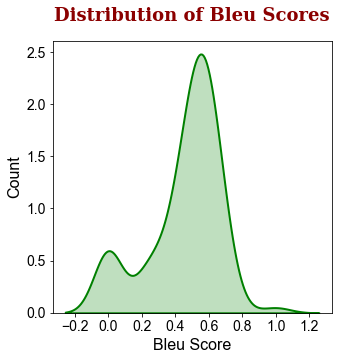

In [9]:
plt.figure(figsize = (5, 5))
ax = sns.distplot(bleu_scores, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green")
plt.title("Distribution of Bleu Scores", fontdict = title_font, pad = 20.0)
plt.xlabel("Bleu Score", fontdict = label_font)
plt.ylabel("Count", fontdict = label_font)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(14)
plt.show()

<p class = "text">
The distribution shows that the model achieves the bleu score of around 0.6 for majority of the sentences. Let us generate a random prediction using this model.
</p>

In [ ]:
print("Informal Sentence: wat r ya sayin")
print(f"Formal Prediction: {predict('wat r ya sayin', model)}")

Informal Sentence: wat r ya sayin
Formal Prediction: What are you are to shee you?


<p class = "text">
The model corrected the words 'wat', 'r', 'ya' to 'What', 'are', and 'you' respectively alongwith capitalizing the first letter. It also correctly introduced '?' at the end. But more importantly, the prediction is not meaningful or convincing. This issue can be overcome by training the model on large dataset. 
</p>

<h2>4. Error Analysis:</h2>

<p class = "text">
Now, we will analyze the behaviour of this model on test dataset by checking the best and worst predictions made by the model. For that we will have to sort the bleu scores achieved by the model on the test set, and then print the corresponding predictions.
</p>

In [ ]:
# Sorting the indices by blue scores
scores = np.array(bleu_scores)
indices = np.argsort(scores)
# Getting worst score indices
worst = indices[:5]
# Getting best score indices
best = indices[-5:][::-1]
print('Best Predictions:')
print("-"*50)
for i in best:
    print(f"Informal Input : {test['informals'].iloc[i]}")
    print(f"Expected Output : {' '.join(test['formals'].iloc[i][0])}")
    print(f"Predicted Output : {' '.join(test['predictions'].iloc[i])}")
    print(f"Bleu Score of Prediction : {scores[i]}")
    print("\n")
print('='*100)
print('Worst Predictions:')
print("-"*50)
for i in worst:
    print(f"Informal Input : {test['informals'].iloc[i]}")
    print(f"Expected Output : {' '.join(test['formals'].iloc[i][0])}")
    print(f"Predicted Output : {' '.join(test['predictions'].iloc[i])}")
    print(f"Bleu Score of Prediction : {scores[i]}")
    print("\n")

Best Predictions:
--------------------------------------------------
Informal Input : How are you
Expected Output : How are you?
Predicted Output : How are you?
Bleu Score of Prediction : 1.0


Informal Input : Where are you
Expected Output : Where are you?
Predicted Output : Where are you are you?
Bleu Score of Prediction : 0.7400828044922853


Informal Input : Nope... I'm reaching home. Take my bag then go sch.
Expected Output : No. I'm reaching home. Take my bag and then go to school.
Predicted Output : No. I am not and see you are to see you and stay.
Bleu Score of Prediction : 0.6930977286178778


Informal Input : Hmmm... Not sure... Y? I might go shop shop...
Expected Output : Hmmm. I'm not sure. Why? I might go shopping.
Predicted Output : Hmm. I am not still then we can already?
Bleu Score of Prediction : 0.6865890479690392


Informal Input : hey gals,anyone of ü know how to knit a sweater or know where to learn ñ get ematerials?
Expected Output : Hey, girls, is there anyone of

<p class = "text">
The important observation regarding the predictions is that be it best predictions or worst predictions, the model is capable of correcting the misspellings, capitalizations, and punctuations. The predictions with higher bleu score have more words overlapping with ground truth. The worst predictions however, are for the instances where there are lot of misspellings and incorrect capitalizations as the model is sensitive to it. Nevertheless, the model is trained on very little data and hence has lot of scope for improvement with large datasets like GYAFC corpus.
</p>